# LSTM baseline

## Univariate Time Series Regression

This notebook demonstrates how to forecast the S&P 500 index using a Recurrent Neural Network.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Get Data

We obtain data for 2010-2018 from the Federal Reserve Bank’s Data Service [FRED](https://fred.stlouisfed.org/) using the [pandas_datareader](https://pandas-datareader.readthedocs.io/) library in introduced in [Chapter 2 on Market and Fundamental Data](../02_market_and_fundamental_data).

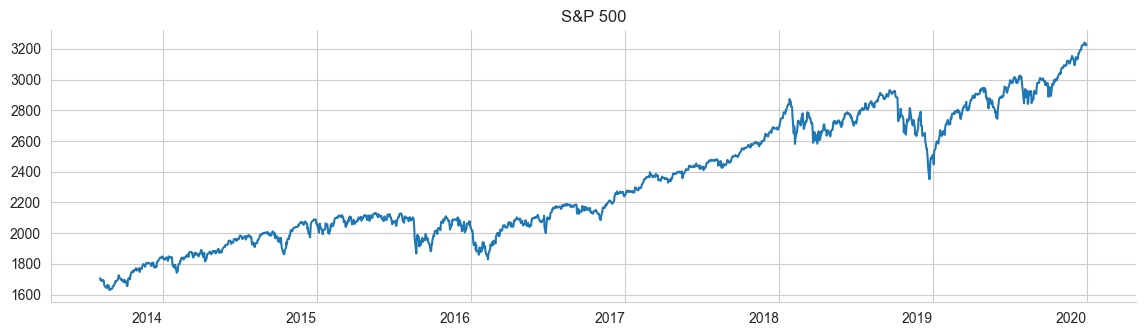

In [50]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [10]:
sp500.head()

,SP500
DATE,
2013-08-05,1707.14
2013-08-06,1697.37
2013-08-07,1690.91
2013-08-08,1697.48
2013-08-09,1691.42


## Preprocessing

In [11]:
scaler = MinMaxScaler()

In [12]:
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)
sp500_scaled.describe()

count    1614.000000
mean        0.431443
std         0.248736
min         0.000000
25%         0.236754
50%         0.338454
75%         0.668172
max         1.000000
dtype: float64

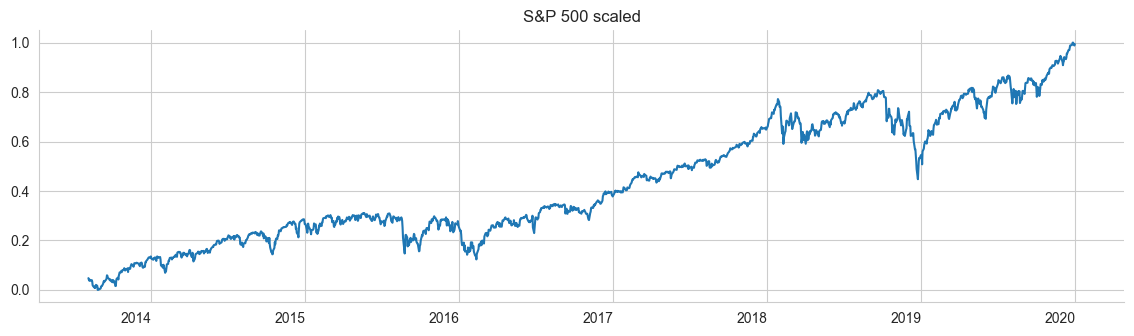

In [13]:
ax = sp500_scaled.plot(title='S&P 500 scaled',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

## Génération de séquence 

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline  {\langle x_1,x_2,x_3,x_4,x_5\rangle} & { x_6} \\
\ {\langle x_{2},x_{3},x_{4},x_{5},x_{6} \rangle } & {x_{7} } \\
  {\vdots} & {\vdots}\\
 { \langle x_{T-5},x_{T-4},x_{T-3},x_{T-2},x_{T-1} \rangle } &  {x_{T}}
\end{array}$$

Generally speaking, for window size S, the relationship takes the form 

$$x_t = f( x_{t-1}, x_{t-2}, ..., x_{t-S}) \quad\forall t=S, S+1, ..., T$$

Each of the $T-S$ lagged input sequence or vector is of length S with a corresponding scalar output.

We can use the function create_univariate_rnn_data() to stack sequences selected using a rolling windows:

In [14]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

We apply this function to the rescaled stock index for a window_size=63 to obtain a two-dimensional dataset of shape number of samples x number of timesteps:

In [15]:
window_size = 63

In [16]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [17]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2013-11-01,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,0.039564,0.034115,0.019161,0.015750,...,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327,0.081781,0.087895,0.082527,0.078321
2013-11-04,0.041558,0.037545,0.041627,0.037862,0.036650,0.039564,0.034115,0.019161,0.015750,0.009680,...,0.070940,0.077159,0.072008,0.075543,0.080327,0.081781,0.087895,0.082527,0.078321,0.081489
2013-11-05,0.037545,0.041627,0.037862,0.036650,0.039564,0.034115,0.019161,0.015750,0.009680,0.013588,...,0.077159,0.072008,0.075543,0.080327,0.081781,0.087895,0.082527,0.078321,0.081489,0.085397
2013-11-06,0.041627,0.037862,0.036650,0.039564,0.034115,0.019161,0.015750,0.009680,0.013588,0.007654,...,0.072008,0.075543,0.080327,0.081781,0.087895,0.082527,0.078321,0.081489,0.085397,0.082315
2013-11-07,0.037862,0.036650,0.039564,0.034115,0.019161,0.015750,0.009680,0.013588,0.007654,0.016452,...,0.075543,0.080327,0.081781,0.087895,0.082527,0.078321,0.081489,0.085397,0.082315,0.086988


In [18]:
y.head()

DATE
2013-11-01    0.081489
2013-11-04    0.085397
2013-11-05    0.082315
2013-11-06    0.086988
2013-11-07    0.072487
dtype: float64

In [19]:
X.shape

(1551, 63)

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

In [21]:
print("Column Names:", X.columns)

Column Names: RangeIndex(start=0, stop=63, step=1)


In [22]:
# Check the index values
print("Index Values:", X.index)

Index Values: DatetimeIndex(['2013-11-01', '2013-11-04', '2013-11-05', '2013-11-06',
               '2013-11-07', '2013-11-08', '2013-11-11', '2013-11-12',
               '2013-11-13', '2013-11-14',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='DATE', length=1551, freq=None)


In [24]:
# Assuming X is your DataFrame with a time index and columns representing time series data

# Define the window size
window_size = 63

# Create the training set up to the year 2018
X_train = X[:'2018'].values.reshape(-1, window_size, 1)
y_train = y[:'2018']

# Create the testing set for the year 2019
X_test = X[X.index.year == 2019].values.reshape(-1, window_size, 1)
y_test = y[y.index.year == 2019]

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1299, 63, 1)
y_train shape: (1299,)
X_test shape: (252, 63, 1)
y_test shape: (252,)


In [25]:
n_obs, window_size, n_features = X_train.shape

In [26]:
y_train.shape

(1299,)

## Keras LSTM Layer

Keras has several built-in RNN layers with various configuration options described in detail in the [documentation](https://keras.io/layers/recurrent/).

```
LSTM(units,
     activation='tanh',
     recurrent_activation='hard_sigmoid',
     use_bias=True,
     kernel_initializer='glorot_uniform',
     recurrent_initializer='orthogonal',
     bias_initializer='zeros',
     unit_forget_bias=True,
     kernel_regularizer=None,
     recurrent_regularizer=None,
     bias_regularizer=None,
     activity_regularizer=None,
     kernel_constraint=None,
     recurrent_constraint=None,
     bias_constraint=None,
     dropout=0.0,
     recurrent_dropout=0.0,
     implementation=1,
     return_sequences=False,
     return_state=False,
     go_backwards=False,
     stateful=False,
     unroll=False)
 ```

##  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [27]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

The summary shows that the model has 1,781 parameters:

In [28]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Train the Model

We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:

In [32]:
optimizer = keras.optimizers.legacy.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [33]:
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

We define an EarlyStopping callback and train the model for up to 100 episodes. 

In [34]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

In [36]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150
64/65 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 1: val_loss improved from inf to 0.00297, saving model to results/univariate_time_series\rnn.h5
65/65 [==============================] - 3s 21ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 2/150
63/65 [============================>.] - ETA: 0s - loss: 4.9409e-04
Epoch 2: val_loss improved from 0.00297 to 0.00096, saving model to results/univariate_time_series\rnn.h5
65/65 [==============================] - 1s 15ms/step - loss: 5.1193e-04 - val_loss: 9.6282e-04
Epoch 3/150
65/65 [==============================] - ETA: 0s - loss: 4.7037e-04
Epoch 3: val_loss did not improve from 0.00096
65/65 [==============================] - 1s 12ms/step - loss: 4.7037e-04 - val_loss: 0.0017
Epoch 4/150
64/65 [============================>.] - ETA: 0s - loss: 4.4640e-04
Epoch 4: val_loss did not improve from 0.00096
65/65 [==============================] - 1s 12ms/step - loss: 4.4538e-04 - val_loss: 0.0013
Epoch 5/150
64

65/65 [==============================] - 1s 12ms/step - loss: 2.3423e-04 - val_loss: 2.3159e-04
Epoch 35/150
65/65 [==============================] - ETA: 0s - loss: 2.3618e-04
Epoch 35: val_loss did not improve from 0.00023
65/65 [==============================] - 1s 13ms/step - loss: 2.3618e-04 - val_loss: 3.0474e-04
Epoch 36/150
63/65 [============================>.] - ETA: 0s - loss: 2.3948e-04
Epoch 36: val_loss did not improve from 0.00023
65/65 [==============================] - 1s 13ms/step - loss: 2.3943e-04 - val_loss: 5.8876e-04
Epoch 37/150
63/65 [============================>.] - ETA: 0s - loss: 2.3836e-04
Epoch 37: val_loss did not improve from 0.00023
65/65 [==============================] - 1s 13ms/step - loss: 2.3414e-04 - val_loss: 4.2239e-04
Epoch 38/150
65/65 [==============================] - ETA: 0s - loss: 2.3313e-04
Epoch 38: val_loss did not improve from 0.00023
65/65 [==============================] - 1s 13ms/step - loss: 2.3313e-04 - val_loss: 4.1106e-04
Epoc

Epoch 70/150
62/65 [===========================>..] - ETA: 0s - loss: 1.7369e-04
Epoch 70: val_loss did not improve from 0.00020
65/65 [==============================] - 1s 13ms/step - loss: 1.8083e-04 - val_loss: 2.9498e-04
Epoch 71/150
61/65 [===========================>..] - ETA: 0s - loss: 1.7767e-04
Epoch 71: val_loss did not improve from 0.00020
65/65 [==============================] - 1s 13ms/step - loss: 1.7565e-04 - val_loss: 2.1541e-04
Epoch 72/150
65/65 [==============================] - ETA: 0s - loss: 1.7876e-04
Epoch 72: val_loss did not improve from 0.00020
65/65 [==============================] - 1s 13ms/step - loss: 1.7876e-04 - val_loss: 9.3199e-04
Epoch 73/150
62/65 [===========================>..] - ETA: 0s - loss: 1.7595e-04
Epoch 73: val_loss did not improve from 0.00020
65/65 [==============================] - 1s 13ms/step - loss: 1.7326e-04 - val_loss: 4.0848e-04
Epoch 74/150
63/65 [============================>.] - ETA: 0s - loss: 1.8758e-04
Epoch 74: val_loss 

Epoch 106/150
62/65 [===========================>..] - ETA: 0s - loss: 1.5866e-04
Epoch 106: val_loss did not improve from 0.00019
65/65 [==============================] - 1s 13ms/step - loss: 1.6058e-04 - val_loss: 3.2267e-04
Epoch 107/150
61/65 [===========================>..] - ETA: 0s - loss: 1.6172e-04
Epoch 107: val_loss did not improve from 0.00019
65/65 [==============================] - 1s 13ms/step - loss: 1.6411e-04 - val_loss: 2.0492e-04
Epoch 108/150
63/65 [============================>.] - ETA: 0s - loss: 1.5544e-04
Epoch 108: val_loss did not improve from 0.00019
65/65 [==============================] - 1s 13ms/step - loss: 1.5574e-04 - val_loss: 3.3067e-04


Training stops after 51 epochs; the `early_stopping` callback restores the weights for the best model (after 41 epochs)

## Evaluate model performance

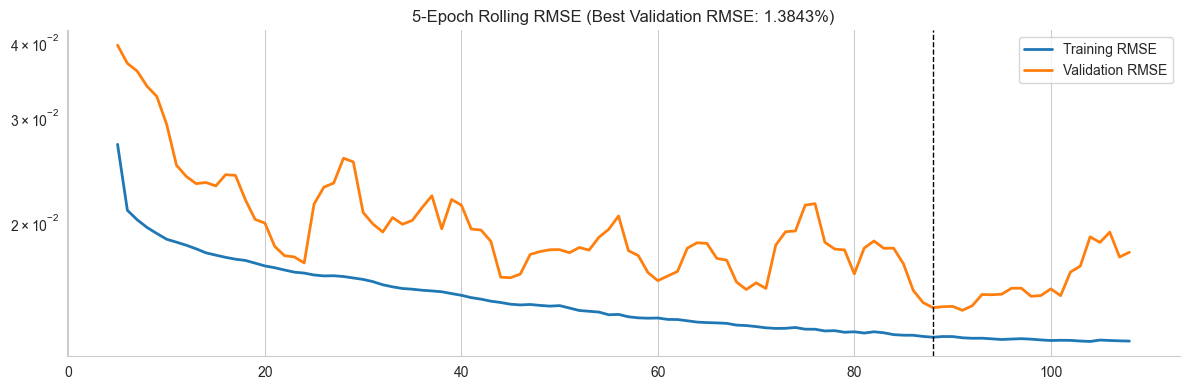

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [38]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0120 | Test RMSE: 0.0138


In [39]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

8/8 [==============================] - 0s 4ms/step


In [40]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9959 | Test IC: 0.9811


##### Prédictions originale
Les données sont rescalé à la valeur d'origine 

In [41]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))

In [42]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [43]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 19.26 | Test RMSE: 22.28'

In [51]:
import pandas as pd

# Assuming sp500 is your DataFrame with stock data

# Add 'Train Predictions' and 'Test Predictions' columns
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict

# Create a DataFrame for training set predictions with 'data' column as 'Train'
train_predictions_df = pd.DataFrame({'predictions': train_predict, 'data': 'Train'}, index=sp500[:len(train_predict)].index)

# Create a DataFrame for test set predictions with 'data' column as 'Test'
test_predictions_df = pd.DataFrame({'predictions': test_predict, 'data': 'Test'}, index=sp500[-len(test_predict):].index)

# Concatenate the two DataFrames vertically
predictions_df = pd.concat([train_predictions_df, test_predictions_df])

# Join the predictions DataFrame with the original sp500 DataFrame
sp500 = sp500.join(predictions_df)


In [52]:
sp500.head(100)

,SP500,Train Predictions,Test Predictions,predictions,data
DATE,,,,,
2013-08-05,1707.14,NaN,NaN,NaN,Train
2013-08-06,1697.37,NaN,NaN,NaN,Train
2013-08-07,1690.91,NaN,NaN,NaN,Train
2013-08-08,1697.48,NaN,NaN,NaN,Train
2013-08-09,1691.42,NaN,NaN,NaN,Train
...,...,...,...,...,...
2013-12-18,1810.65,1786.314453,NaN,1786.314453,Train
2013-12-19,1809.60,1805.432373,NaN,1805.432373,Train
2013-12-20,1818.32,1811.164429,NaN,1811.164429,Train


In [45]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict
sp500 = sp500.join(train_predict.to_frame('predictions').assign(data='Train').append(test_predict.to_frame('predictions').assign(data='Test')))

AttributeError: 'DataFrame' object has no attribute 'append'

### Plot Results

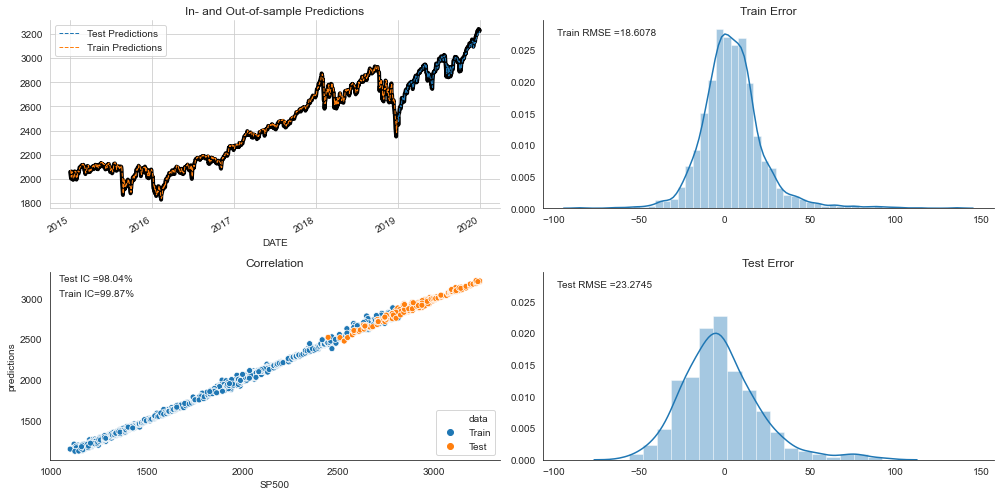

In [37]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

sp500.loc['2015':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500.loc['2015':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);

In [ ]:
RFE

In [ ]:
sel= RFE(GradientBoostingRegressor(n_estimators=100,random_state=0),n_features_to_select=15)
sel.fit(X_train1,y_train1)

In [ ]:
features=X_train.columns[sel.get_support()]
features

In [ ]:
sel.get_support()
array([False,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True, False, False, False,  True,  True,  True,
        True, False, False, False, False])

In [ ]:
X_train_rfe= sel.transform(X_train1)
X_test_rfe= sel.transform(X_test1)